# Thick Sample Ptychography Forward Model Tutorial 2D

This tutorial demonstrates how to use `thick_ptycho` to set up and solve a 2D forward problem with multiple probes, both iteratively and as a full system.


The forward model solves the paraxial equation:

\begin{equation}
\frac{\partial u}{\partial z} = a \frac{\partial^2 u}{\partial x^2}  + C(x, z) u,
\end{equation}
where
\begin{equation}
a := \frac{1}{2ik} \qquad \text{and} \qquad C(x, z) := \frac{k}{2i} \left(n^2(x, z) - 1\right)
\end{equation}


**$n$ defines the refractive index of the volume. $k$ is the wave number.**

### 1. Import Libraries: Sample Space and Forward Model


In [3]:
# from thick_ptycho.sample_space.sample_space import SampleSpace
# from thick_ptycho.forward_model.solver import ForwardModel
from thick_ptycho.simulation.config import SimulationConfig, BoundaryType, ProbeType
from thick_ptycho.simulation.simulation_space import create_simulation_space
from thick_ptycho.simulation.ptycho_object import create_ptycho_object
from thick_ptycho.simulation.ptycho_probe import create_ptycho_probes
from thick_ptycho.forward_model import PWEIterativeLUSolver, PWEFullPinTSolver, MSForwardModelSolver
from matplotlib import pyplot as plt
import time

from thick_ptycho.reconstruction.ms_reconstructor import ReconstructorMS
from thick_ptycho.reconstruction.pwe_reconstructor import ReconstructorPWE

import numpy as np

### 2. Set Simulation Parameters

Choose boundary conditions, probe type, and define the spatial domain and discretization.

2025-11-05 10:51:16,428 - INFO - === Scan Summary (Continuous) ===
2025-11-05 10:51:16,432 - INFO -   Sample space (x-range): 1.000e-04 m
2025-11-05 10:51:16,434 - INFO -   Sample space (z-range): 7.500e-05 m
2025-11-05 10:51:16,439 - INFO -   Probe diameter:         2.000e-06 m
2025-11-05 10:51:16,445 - INFO -   Number of scan points:  60
2025-11-05 10:51:16,448 - INFO -   Steps in z:             312
2025-11-05 10:51:16,450 - INFO -   Detector Pixels:        2560
2025-11-05 10:51:16,454 - INFO -   Max Overlap:            1.218e-06 m
2025-11-05 10:51:16,456 - INFO -   Percentage Overlap:     1559000000.00%



312


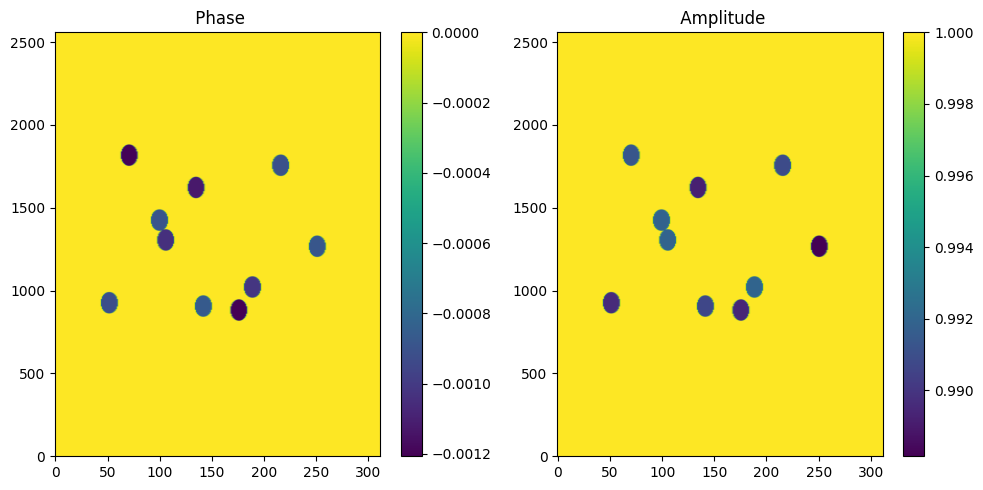

In [ ]:
wavelength = 0.635e-6        # meters (0.635 μm)
k0 = 2 * np.pi / wavelength  # wavenumber [1/m]


# --- Refractive index parameters ---
n_medium = 1.0               # background refractive index

# --- Probe configuration ---
probe_dimensions_discrete = [100]
probe_diameter_scale = 0.02
probe_focus = -5e-6                    # focal length [m]
scan_points = 60
step_size = 20                        # pixels between scans

pad_factor = 2.0  # Portion of extra space to add
# Define margin portion (half of extra space)
pad_margin = (pad_factor - 1) / 2.0

# --- Simulation spatial dimensions (in meters) ---
xlims = [0.0, 100e-6]   # meters (sample width)
zlims = [0.0, 75e-6]   # meters (sample thickness)
continuous_dimensions = (xlims, zlims)

# TODO: Make this padding apply to all dimensions
probe_width = probe_dimensions_discrete[0]
min_nx = (scan_points - 1) * step_size + probe_width
nx = int(min_nx * pad_factor)
dx = (xlims[1] - xlims[0])/nx


detector_pixels = 256
pixel_dx = (xlims[1] - xlims[0])/detector_pixels

# --- Discretization parameters ---
z_range = zlims[1] - zlims[0]
#dz = (pixel_dx)**2/wavelength
dz = wavelength / 4 
nz = int(z_range / dz)


# TODO: Make this padding apply to all dimensions
probe_width = probe_dimensions_discrete[0]
min_nx = (scan_points - 1) * step_size + probe_width
discrete_dimensions = (int(min_nx * pad_factor), nz)


# --- Enumerated configuration types ---
bc_type = BoundaryType.IMPEDANCE
probe_type = ProbeType.AIRY_DISK

# --- Create the SimulationConfig object ---
config = SimulationConfig(
    continuous_dimensions=continuous_dimensions,
    discrete_dimensions=discrete_dimensions,
    probe_dimensions=probe_dimensions_discrete,
    scan_points=scan_points,
    step_size=step_size,
    bc_type=bc_type,
    probe_type=probe_type,
    wave_number=k0,
    probe_diameter_scale=probe_diameter_scale,
    #probe_angles=(np.linspace(-15,15,3)),
    probe_focus=probe_focus,
    tomographic_projection_90_degree=True,
    thin_sample=False,
    n_medium=n_medium,
    results_dir="./results",
    use_logging=True
)

# --- Create the simulation space ---
simulation_space = create_simulation_space(config)
simulation_space.summarize()

# --- Create a Simultated Ptycho Object ---
ptycho_object = create_ptycho_object(simulation_space)


# # TODO: Make objects move to the centre with padding or define them in min_nx
# # Add 6 spheres of varying positions
# # Base refractive index offsets
delta = 0.01
beta = 0.001

# # Variation strength (fractional)
delta_var = 0.20   # ±20% variation in phase shift
beta_var  = 0.20   # ±20% variation in absorption

gaussian_blur = 0.5
common_side_length = 0.05
common_depth = 0.05
num_circles = 10
random_seed = 5

np.random.seed(random_seed)

# Generate random (x,z) centers
x_centers = np.random.uniform(0.25, 0.75, size=num_circles)
z_centers = np.random.uniform(0.1, 0.9, size=num_circles)

for cx, cz in zip(x_centers, z_centers):

    # Randomize refractive index perturbation per circle
    delta_rand = delta * (1 + delta_var * (np.random.rand() - 0.5) * 2)
    beta_rand  = beta  * (1 + beta_var  * (np.random.rand() - 0.5) * 2)

    refractive_index_perturbation = -delta_rand - 1j * beta_rand

    ptycho_object.add_object(
        'circle',
        refractive_index_perturbation,
        side_length=common_side_length,
        centre=(cx, cz),
        depth=common_depth,
        gaussian_blur=gaussian_blur
    )
ptycho_object.build_field()
# ptycho_object.create_refractive_index_of_phantom(
#     real_perturbation=delta,
#     imaginary_perturbation=beta
# )
simulation_space.viewer.plot_two_panels(ptycho_object.n_true, view="phase_amp")


# --- Create a set of Simulated Ptycho Probes ---
ptycho_probes = create_ptycho_probes(simulation_space)


### 5. Solve the Forward Model


Solution is a complex propagated field, shape:

(num_projections, num_angles, num_probes, nx[,ny], nz).

In [5]:
# Solve Full Space Space, Iterative

# --- Create Forward Model ---
time_start = time.time()
forward_model_pwe = PWEIterativeLUSolver(simulation_space,
                                ptycho_object,
                                ptycho_probes)

# Iterative solution
u_pwe = forward_model_pwe.solve()
time_end = time.time()
print(f"Forward model creation and solving time: {time_end - time_start:.2f} seconds.\n")
exit_waves_pwe = forward_model_pwe.get_exit_waves(u_pwe)
intensities_pwe_noisy = forward_model_pwe.get_farfield_intensities(exit_waves=exit_waves_pwe, 
                                                           poisson_noise=True)
intensities_pwe = forward_model_pwe.get_farfield_intensities(exit_waves=exit_waves_pwe, 
                                                           poisson_noise=False)

Forward model creation and solving time: 4.90 seconds.



In [6]:
# # --- Create Forward Model ---
# time_start = time.time()
# forward_model_pwe_full = ForwardModelPWEFull(simulation_space,
#                                 ptycho_object,
#                                 ptycho_probes,
#                                 use_pit=False)

# # Iterative solution
# u_pwe_full = forward_model_pwe_full.solve()
# time_end = time.time()
# print(f"Forward model creation and solving time: {time_end - time_start:.2f} seconds.\n")
# exit_waves_pwe_full = forward_model_pwe_full.get_exit_waves(u_pwe_full)
# intensities_pwe_noisy_full = forward_model_pwe_full.get_farfield_intensities(exit_waves=exit_waves_pwe_full, 
#                                                            poisson_noise=True)
# intensities_pwe_full = forward_model_pwe_full.get_farfield_intensities(exit_waves=exit_waves_pwe_full, 
#                                                            poisson_noise=False)

In [7]:
# # --- Create Forward Model ---
# time_start = time.time()
# forward_model_pwe_full = ForwardModelPWEFull(simulation_space,
#                                 ptycho_object,
#                                 ptycho_probes,
#                                 use_pit=True,
#                                 alpha=1e-6,
#                                 atol=1e-8,
#                                 num_workers=8)

# # Iterative solution
# u_pwe_full = forward_model_pwe_full.solve()
# time_end = time.time()
# print(f"Forward model creation and solving time: {time_end - time_start:.2f} seconds.\n")
# exit_waves_pwe_full = forward_model_pwe_full.get_exit_waves(u_pwe_full)
# intensities_pwe_noisy_full = forward_model_pwe_full.get_farfield_intensities(exit_waves=exit_waves_pwe_full, 
#                                                            poisson_noise=True)
# intensities_pwe_full = forward_model_pwe_full.get_farfield_intensities(exit_waves=exit_waves_pwe_full, 
#                                                            poisson_noise=False)


# #error = np.linalg.norm(u_pwe_full - u_pwe) / np.linalg.norm(u_pwe)

In [8]:
# print("Relative error between full and iterative PWE solutions:", error)

/home/dnz75396/thick_ptycho/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/dnz75396/thick_ptycho/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


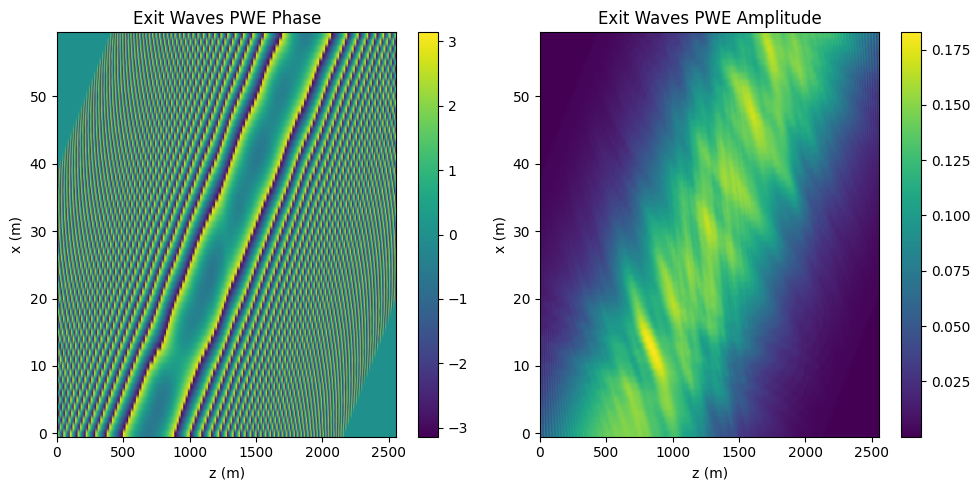

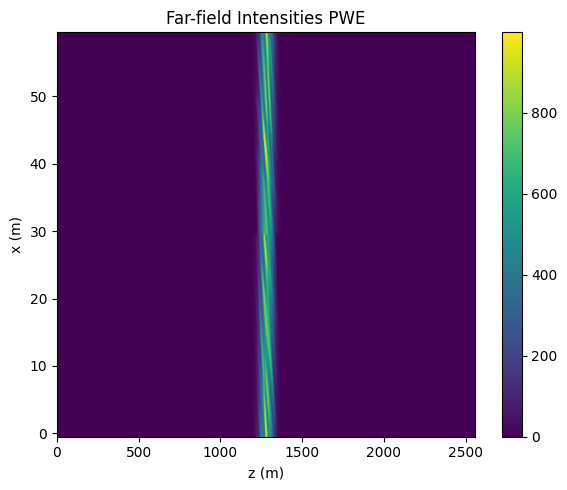

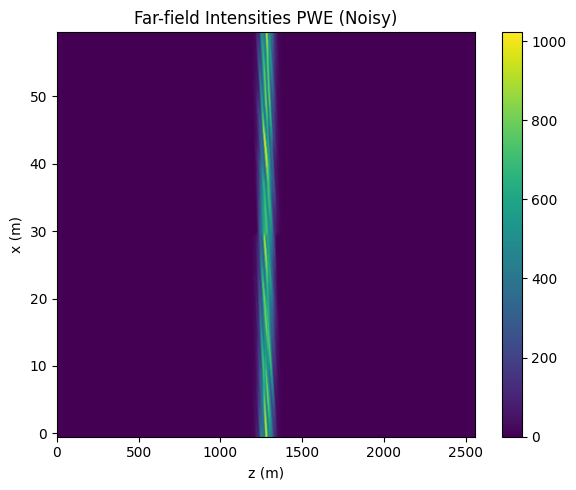

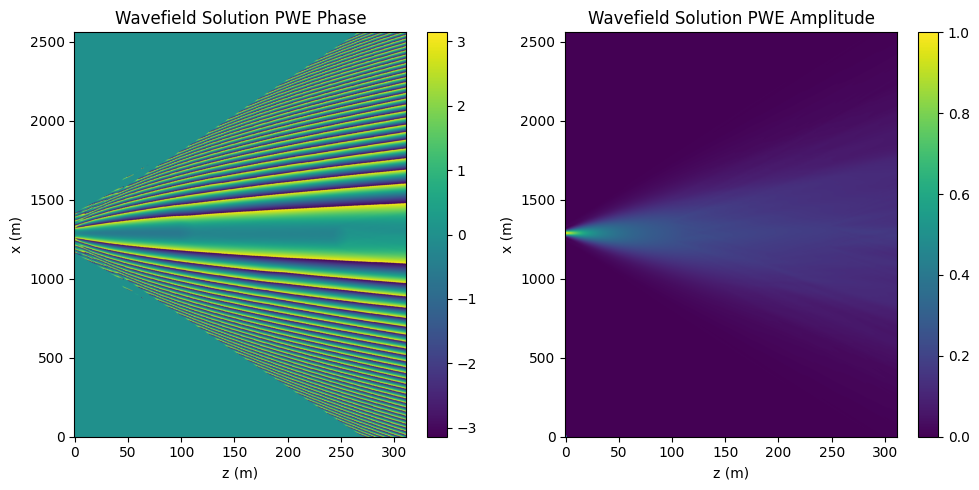

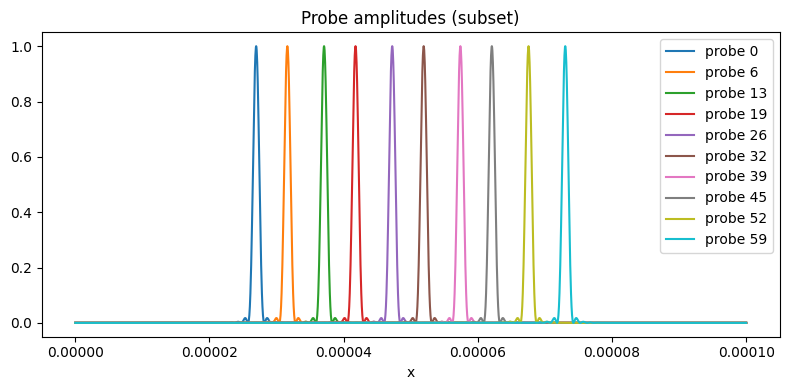

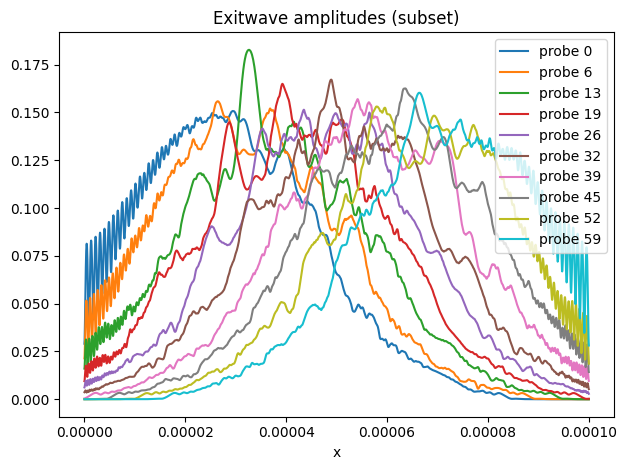

In [9]:
simulation_space.viewer.plot_two_panels(exit_waves_pwe,
                                        view="phase_amp", 
                                        title="Exit Waves PWE",
                                        xlabel="z (m)",
                                        ylabel="x (m)")

simulation_space.viewer.plot_single_panel(np.fft.fftshift(intensities_pwe),
                                        title="Far-field Intensities PWE",
                                        xlabel="z (m)",
                                        ylabel="x (m)")

simulation_space.viewer.plot_single_panel(np.fft.fftshift(intensities_pwe_noisy),
                                        title="Far-field Intensities PWE (Noisy)",
                                        xlabel="z (m)",
                                        ylabel="x (m)")

# Select Centre Probe
centre_probe_pwe = u_pwe[0,0,simulation_space.num_probes//2, ...]
simulation_space.viewer.plot_two_panels(centre_probe_pwe,
                                        view="phase_amp", 
                                        title="Wavefield Solution PWE",
                                        xlabel="z (m)",
                                        ylabel="x (m)")

plt.plot(simulation_space.x, centre_probe_pwe[:, nz//2])
plt.show()

plt.figure(figsize=(8,4))
plot_num_probes = 10#simulation_space.num_probes
probe_indices = np.linspace(0, simulation_space.num_probes-1, plot_num_probes, dtype=int)
for p in probe_indices:
    plt.plot(simulation_space.x, np.abs(u_pwe[0,0,p,:,0]), label=f'probe {p}')
plt.title("Probe amplitudes (subset)")
plt.xlabel("x"); plt.legend(); 
plt.tight_layout(); plt.show()

for p in probe_indices:
    plt.plot(simulation_space.x, np.abs(u_pwe[0,0,p,:,-1]), label=f'probe {p}')
plt.title("Exitwave amplitudes (subset)")
plt.xlabel("x"); plt.legend(); 
plt.tight_layout(); plt.show()


### 6. Inverse Problem Assuming Phase
The exit wave of the forward solution can be set as the initial condition for
the system to be solved in reverse. 

In [10]:
# --- Reconstruction data ---
complex_data = exit_waves_pwe

In [17]:
# Create MS Simulation Space
# dz = wavelength * 16 # For multi-slice, keep dz larger to reduce number of slices
# nz = int(z_range / dz)
dz = (pixel_dx)**2/wavelength
#dz = wavelength / 2 
nz = int(z_range / dz)
discrete_dimensions = (int(min_nx * pad_factor), nz)

# --- Create the SimulationConfig object ---
config_ms = SimulationConfig(
    continuous_dimensions=continuous_dimensions,
    discrete_dimensions=discrete_dimensions,
    probe_dimensions=probe_dimensions_discrete,
    scan_points=scan_points,
    step_size=step_size,
    bc_type=bc_type,
    probe_type=probe_type,
    wave_number=k0,
    probe_diameter_scale=probe_diameter_scale,
    probe_focus=probe_focus,
    tomographic_projection_90_degree=False,
    thin_sample=False,
    n_medium=n_medium,
    results_dir="./results",
    use_logging=True
)
simulation_space_ms = create_simulation_space(config_ms)
simulation_space_ms.summarize()


2025-11-05 10:54:10,628 - INFO - === Scan Summary (Continuous) ===
2025-11-05 10:54:10,629 - INFO -   Sample space (x-range): 1.000e-04 m
2025-11-05 10:54:10,631 - INFO -   Sample space (z-range): 7.500e-05 m
2025-11-05 10:54:10,633 - INFO -   Probe diameter:         2.000e-06 m
2025-11-05 10:54:10,633 - INFO -   Number of scan points:  60
2025-11-05 10:54:10,634 - INFO -   Steps in z:             312
2025-11-05 10:54:10,637 - INFO -   Detector Pixels:        2560
2025-11-05 10:54:10,639 - INFO -   Max Overlap:            1.218e-06 m
2025-11-05 10:54:10,640 - INFO -   Percentage Overlap:     1559000000.00%



Initialized Multislice 3PIE Reconstructor.
[Iter 001] Mean Loss = 194.26591220880047
[Iter 006] Mean Loss = 38.29109660380461
Reconstruction time: 98.31 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residual History'}, xlabel='Iteration', ylabel='RMSE'>)

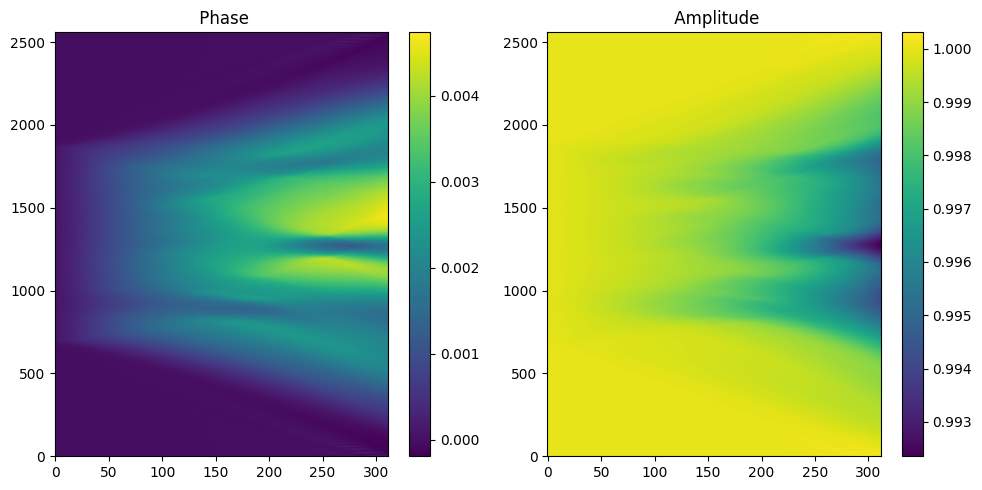

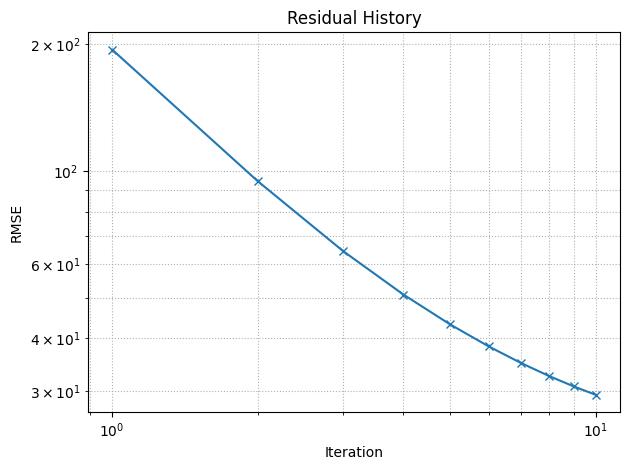

In [ ]:
recon_ms = ReconstructorMS(simulation_space_ms, complex_data.squeeze(), phase_retrieval=False, verbose=True)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=10,alpha_obj=1e-4)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")

simulation_space_ms.viewer.plot_two_panels(n_est_ms,view="phase_amp")
simulation_space_ms.viewer.plot_residual(residual_ms)

In [13]:
recon_pwe = ReconstructorPWE(simulation_space, complex_data, phase_retrieval=False, verbose=True)
time_start = time.time()
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=10)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(n_est_pwe,view="phase_amp")
simulation_space.viewer.plot_residual(residual_pwe)

Initializing Least Squares Solver...
Iteration 1/10
    RMSE: 0.03190917834599643
    Iteration 1 took 23.95 seconds.
Iteration 2/10
    RMSE: 0.03105074682774365


KeyboardInterrupt: 

## Phase Retrieval

In [14]:
# --- Reconstruction data ---
data = intensities_pwe

Initialized Multislice 3PIE Reconstructor.
[Iter 001] Mean Loss = 0.017884813529584938
[Iter 006] Mean Loss = 0.017199475839698115
[Iter 011] Mean Loss = 0.017032070605900698
[Iter 016] Mean Loss = 0.016941701739006696
Reconstruction time: 3.40 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residual History'}, xlabel='Iteration', ylabel='RMSE'>)

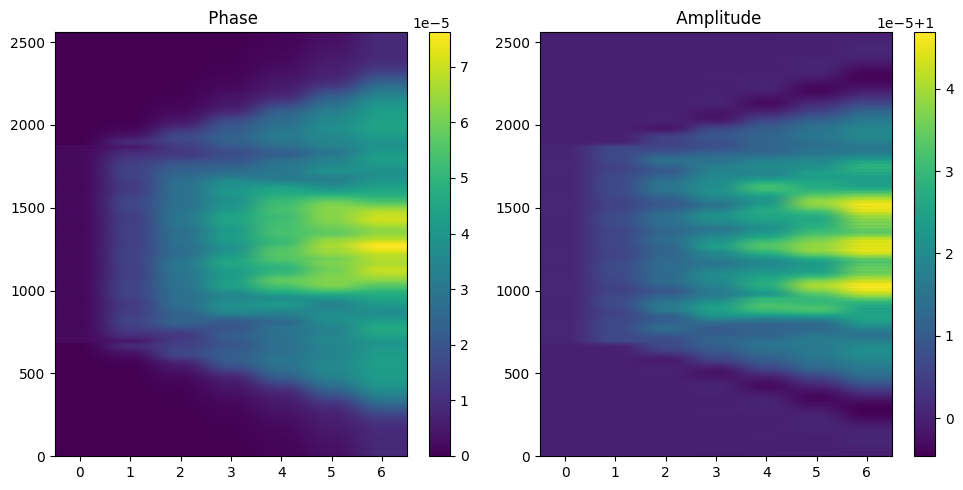

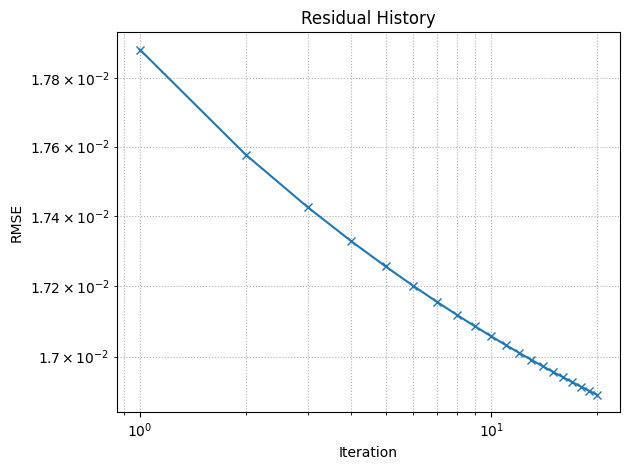

In [16]:

recon_ms = ReconstructorMS(simulation_space_ms, data, phase_retrieval=True, verbose=True)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=20,alpha_obj=1e-4)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space_ms.viewer.plot_two_panels(n_est_ms,view="phase_amp")
simulation_space_ms.viewer.plot_residual(residual_ms)

Initializing Least Squares Solver...
Iteration 1/10
    RMSE: 0.010401956147502299
    Iteration 1 took 11.90 seconds.
Iteration 2/10
    RMSE: 0.01018310853325468
    Iteration 2 took 12.38 seconds.
Iteration 3/10
    RMSE: 0.009971862531211712
    Iteration 3 took 13.35 seconds.
Iteration 4/10
    RMSE: 0.009761173863354353
    Iteration 4 took 12.62 seconds.
Iteration 5/10
    RMSE: 0.009550910617586924
    Iteration 5 took 12.15 seconds.
Iteration 6/10
    RMSE: 0.009340796765383705
    Iteration 6 took 12.35 seconds.
Iteration 7/10
    RMSE: 0.00913053062841343
    Iteration 7 took 12.86 seconds.
Iteration 8/10
    RMSE: 0.00891977570480573
    Iteration 8 took 12.51 seconds.
Iteration 9/10
    RMSE: 0.00870815307532686
    Iteration 9 took 12.13 seconds.
Iteration 10/10
    RMSE: 0.008495231747814693
    Iteration 10 took 12.95 seconds.
Reconstruction time: 125.22 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residual History'}, xlabel='Iteration', ylabel='RMSE'>)

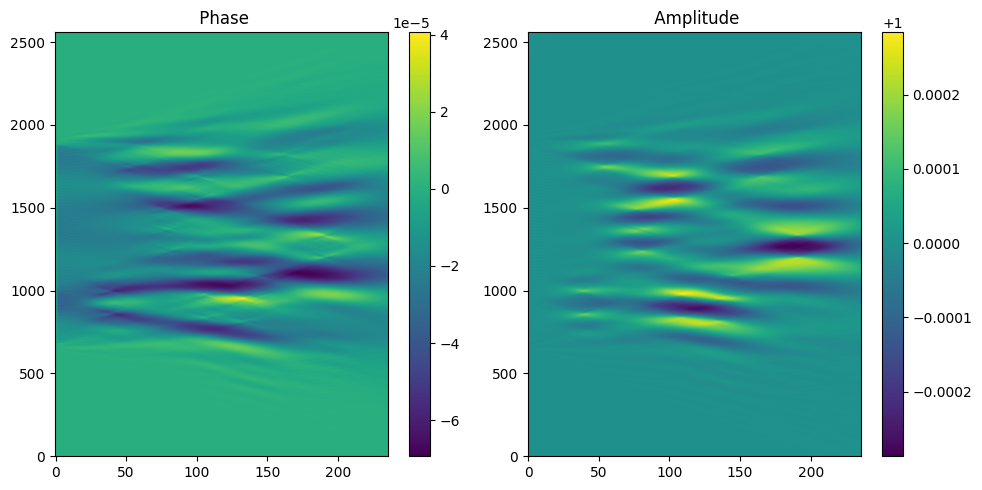

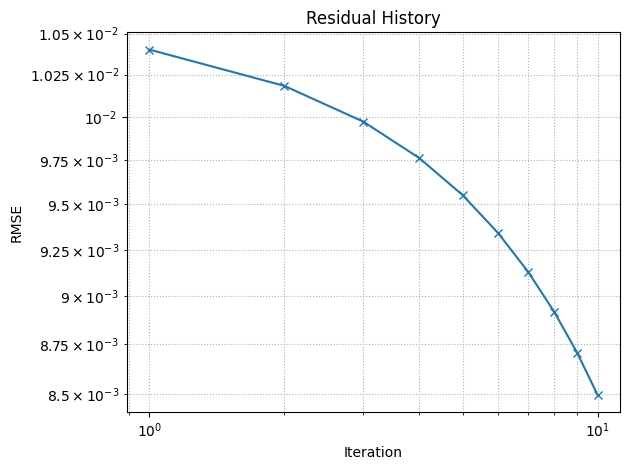

In [ ]:
recon_pwe = ReconstructorPWE(simulation_space, data, phase_retrieval=True, verbose=True)
time_start = time.time()
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=10)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(n_est_pwe,view="phase_amp")
simulation_space.viewer.plot_residual(residual_pwe)

# Phase Retrieval (noisy data)

In [ ]:
rng = np.random.default_rng(seed=42)

data = rng.poisson(intensities_pwe) 


Initialized Multislice 3PIE Reconstructor.
[Iter 001] Mean Loss = 0.01962404393470194
[Iter 002] Mean Loss = 0.019554248667394476
[Iter 003] Mean Loss = 0.01951618890292078
[Iter 004] Mean Loss = 0.019489777856402983
[Iter 005] Mean Loss = 0.01946951037844823
[Iter 006] Mean Loss = 0.01945305569191614
[Iter 007] Mean Loss = 0.019439202663445357
[Iter 008] Mean Loss = 0.019427239720302376
[Iter 009] Mean Loss = 0.019416712706494855
[Iter 010] Mean Loss = 0.019407313854784995
Reconstruction time: 1.35 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residual History'}, xlabel='Iteration', ylabel='RMSE'>)

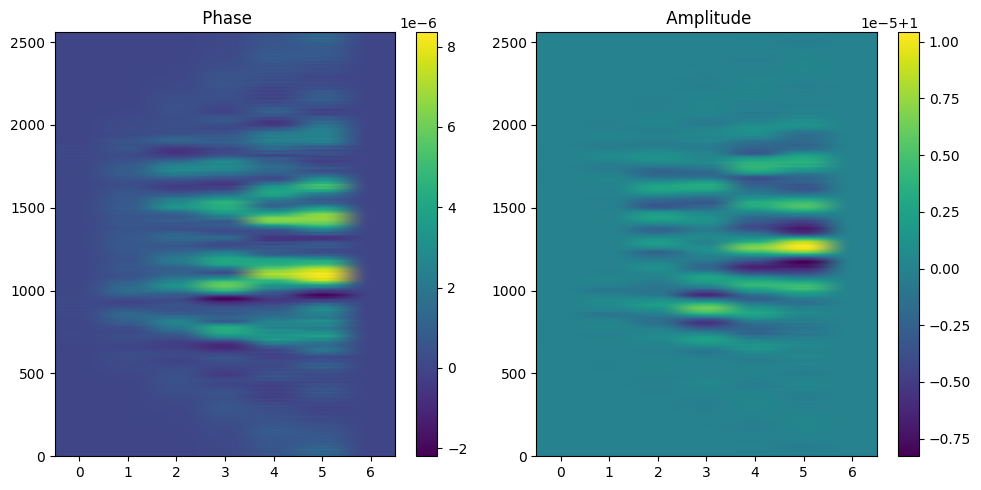

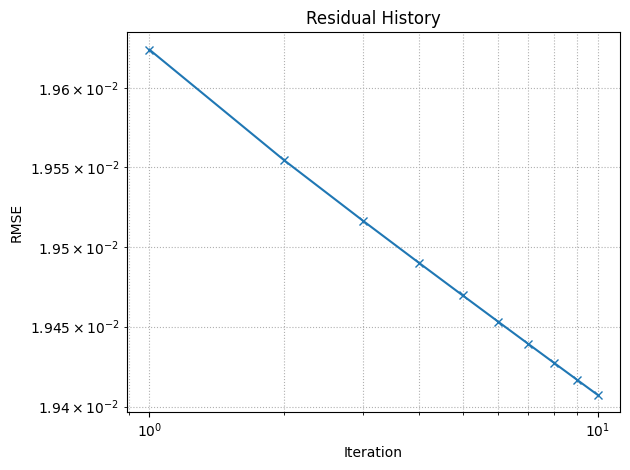

In [ ]:
recon_ms = ReconstructorMS(simulation_space_ms, data, phase_retrieval=True, verbose=True)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=10,alpha_obj=1e-4)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space_ms.viewer.plot_two_panels(n_est_ms,view="phase_amp")
simulation_space_ms.viewer.plot_residual(residual_ms)

Initializing Least Squares Solver...
Iteration 1/10
    RMSE: 0.01094436217473302
    Iteration 1 took 12.73 seconds.
Iteration 2/10
    RMSE: 0.01073237525480603
    Iteration 2 took 14.09 seconds.
Iteration 3/10
    RMSE: 0.010528185996042258
    Iteration 3 took 12.28 seconds.
Iteration 4/10
    RMSE: 0.010324998861557595
    Iteration 4 took 12.83 seconds.
Iteration 5/10
    RMSE: 0.010122709067034613
    Iteration 5 took 13.72 seconds.
Iteration 6/10
    RMSE: 0.009921078330348729
    Iteration 6 took 13.49 seconds.
Iteration 7/10
    RMSE: 0.009719849440106268
    Iteration 7 took 15.33 seconds.
Iteration 8/10
    RMSE: 0.009518738923357313
    Iteration 8 took 14.17 seconds.
Iteration 9/10
    RMSE: 0.009317431663726257
    Iteration 9 took 14.74 seconds.
Iteration 10/10
    RMSE: 0.009115574223870927
    Iteration 10 took 13.36 seconds.
Reconstruction time: 136.79 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residual History'}, xlabel='Iteration', ylabel='RMSE'>)

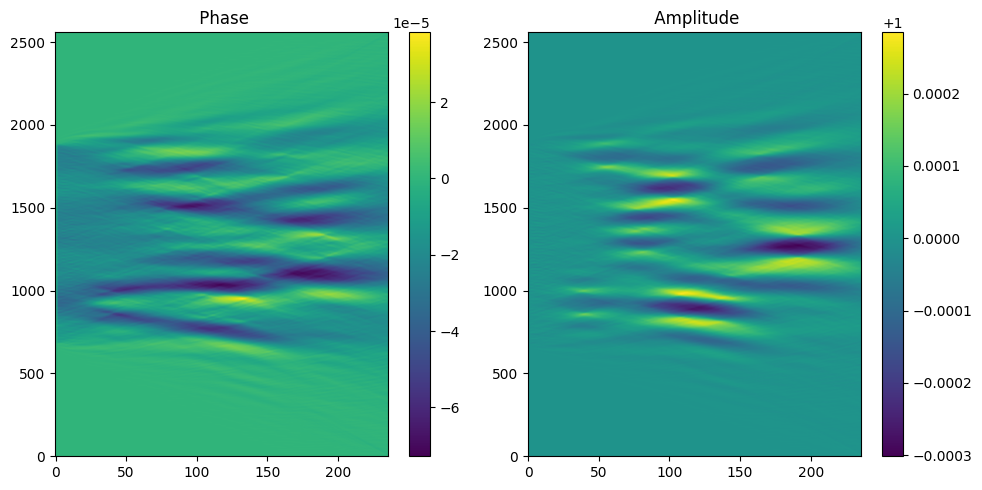

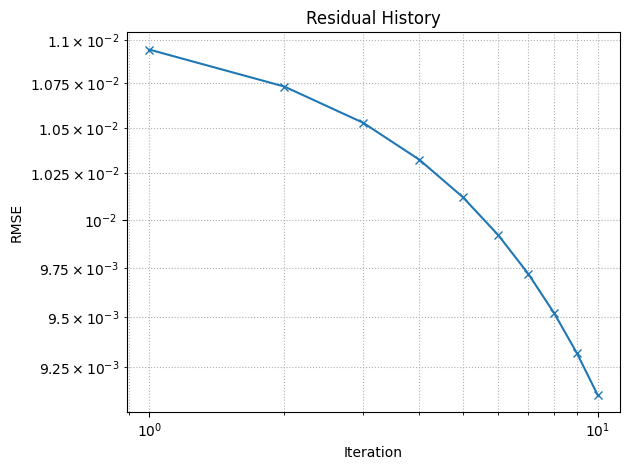

In [ ]:
recon_pwe = ReconstructorPWE(simulation_space, data, phase_retrieval=True, verbose=True)
time_start = time.time()
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=10)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(n_est_pwe,view="phase_amp")
simulation_space.viewer.plot_residual(residual_pwe)